In [10]:
# !pip install moabb

In [9]:
from importlib import reload
import transformers

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt

2023-04-17 16:33:16.115546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import moabb.datasets
sampling_rate = 512

m_dataset = moabb.datasets.bi2013a(
    NonAdaptive=True,
    Adaptive=True,
    Training=True,
    Online=True,
)
output_path = 'output'

# m_dataset.download(path=output_path)
m_data = m_dataset.get_data()

In [6]:
print(m_data[1]['session_1']['run_1'])


<RawArray | 17 x 159232 (311.0 s), ~20.7 MB, data loaded>


In [7]:
channels = m_data[1]['session_1']['run_1'].ch_names[:-1]
channels

['Fp1',
 'Fp2',
 'F5',
 'AFz',
 'F6',
 'T7',
 'Cz',
 'T8',
 'P7',
 'P3',
 'Pz',
 'P4',
 'P8',
 'O1',
 'Oz',
 'O2']

In [8]:
raw_dataset = []

for _, sessions in sorted(m_data.items()):
    eegs, markers = [], []
    for item, run in sorted(sessions['session_1'].items()):
        data = run.get_data()
        eegs.append(data[:-1])
        markers.append(data[-1])
    raw_dataset.append((eegs, markers))

In [11]:
reload(transformers)

decimation_factor = 10
final_rate = sampling_rate // decimation_factor
epoch_duration = 0.9 # seconds
labels_mapping = {33285.: 1, 33286.: 0}
captions = {0: 'empty', 1: 'target'}

eeg_pipe = make_pipeline(
    transformers.Decimator(decimation_factor),
    transformers.ButterFilter(sampling_rate // decimation_factor, 4, 0.5, 20),
    transformers.ChannellwiseScaler(StandardScaler()),
)
markers_pipe = transformers.MarkersTransformer(labels_mapping, decimation_factor)

AttributeError: module transformers has no attribute Decimator

In [ ]:
for eegs, _ in raw_dataset:
    eeg_pipe.fit(eegs)

In [ ]:
dataset = []
epoch_count = int(epoch_duration * final_rate)

for eegs, markers in raw_dataset:
    epochs = []
    labels = []
    filtered = eeg_pipe.transform(eegs)
    markups = markers_pipe.transform(markers)
    for signal, markup in zip(filtered, markups):
        epochs.extend([signal[:, start:(start + epoch_count)] for start in markup[:, 0]])
        labels.extend(markup[:, 1])
    dataset.append((np.array(epochs), np.array(labels)))

In [ ]:
dataset[0][0].shape, dataset[0][0].dtype, dataset[0][1].shape

((1308, 16, 45), dtype('float64'), (1308,))

## Исследование и визуализация данных


In [ ]:
raw_sample = raw_dataset[0][0][0] 

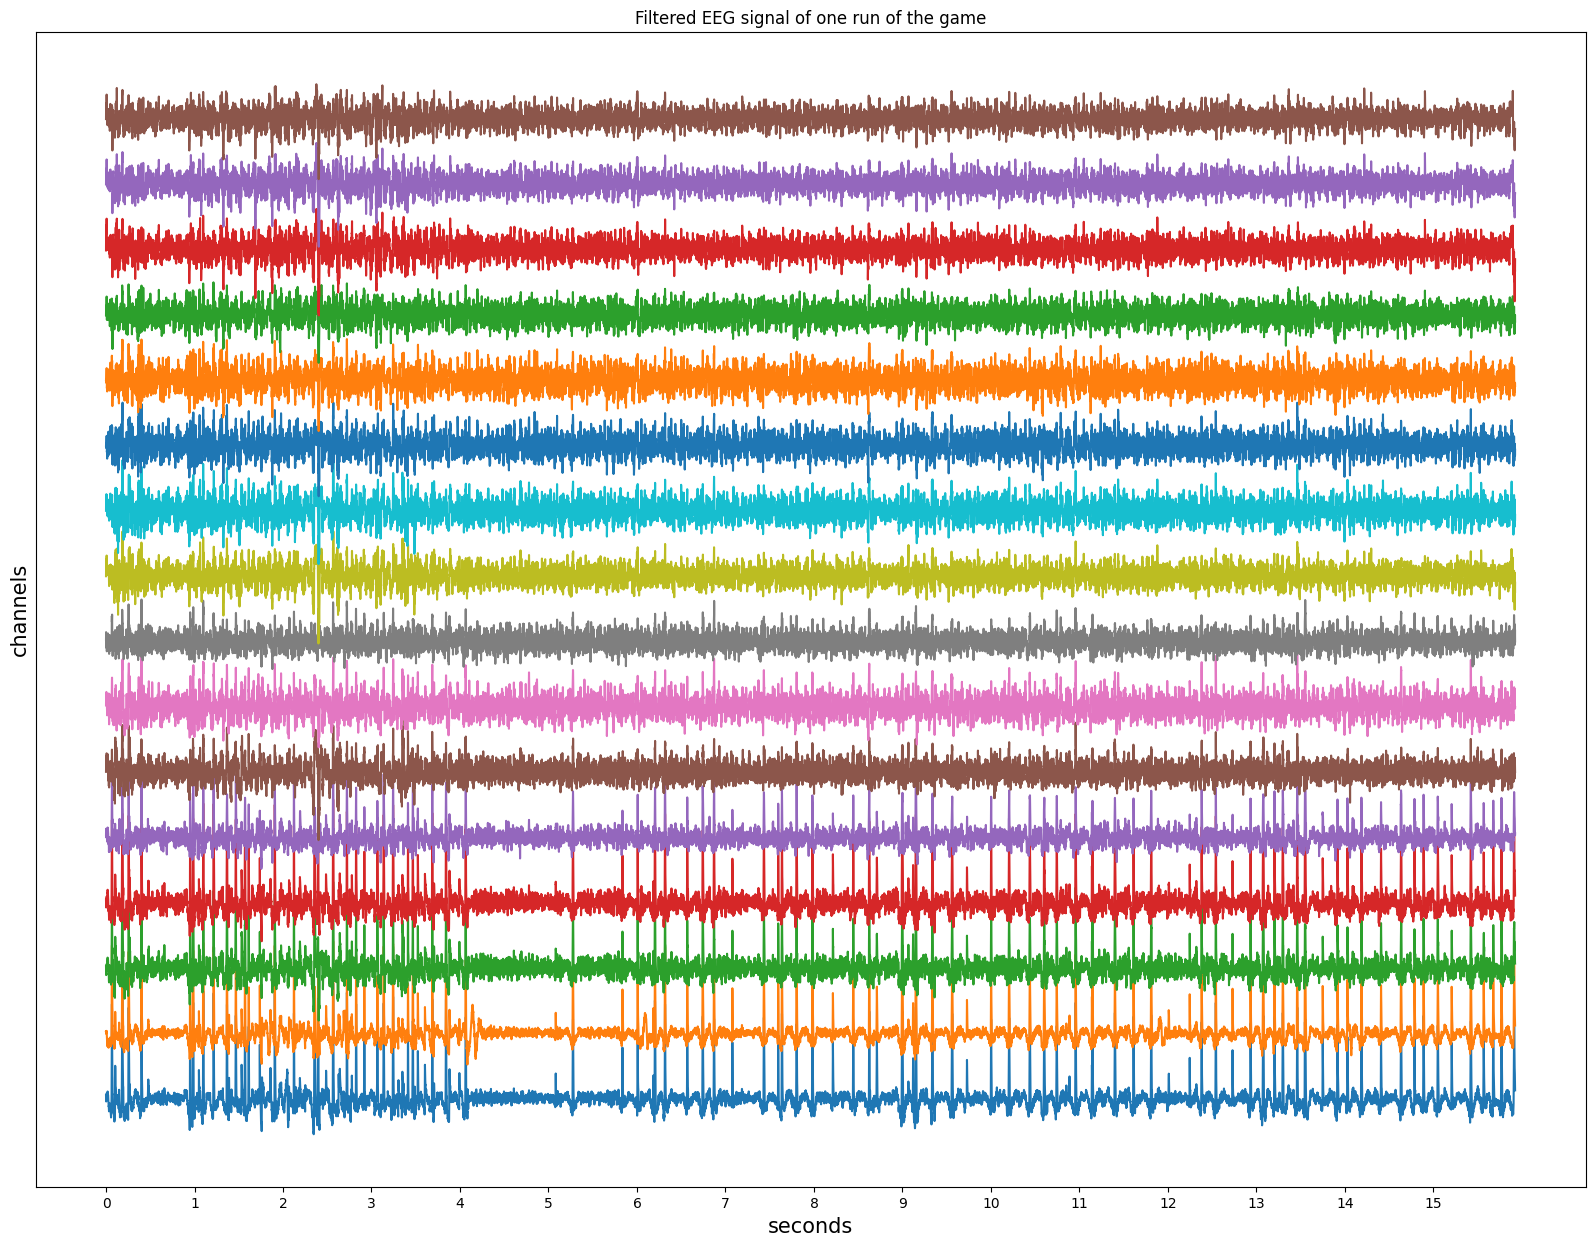

In [ ]:
epoch = eeg_pipe.fit_transform([raw_sample])[0]
plt.figure(figsize=(20, 15))
plt.plot(epoch.T + np.arange(len(epoch))*5)
plt.yticks([])
plt.xticks(np.arange(0, 16000, 1000), np.arange(0, 16, 1))
plt.xlabel('seconds', fontsize=15)
plt.ylabel('channels', fontsize=15)
plt.title('Filtered EEG signal of one run of the game')
plt.show()

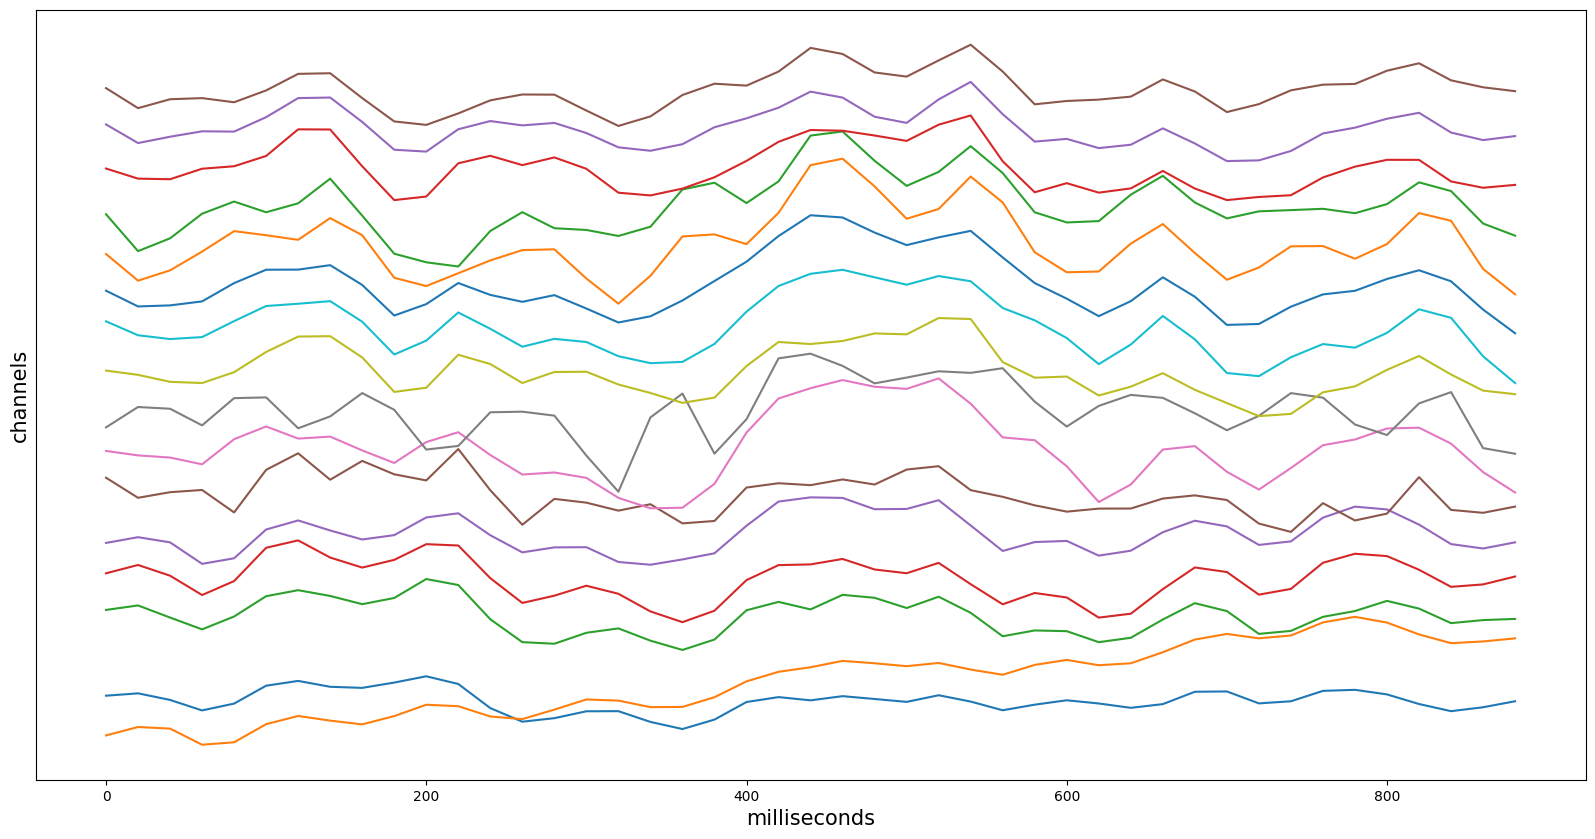

In [ ]:
epoch = dataset[0][0][0]
plt.figure(figsize=(20, 10))
plt.plot(epoch.T + np.arange(len(epoch)))
plt.yticks([])
plt.xticks(np.arange(0, 50, 10), np.arange(0, 1000, 200))
plt.xlabel('milliseconds', fontsize=15)
plt.ylabel('channels', fontsize=15)
plt.show()

In [ ]:
all_epochs = np.concatenate([epochs for epochs, _ in dataset])
all_epochs.shape, all_epochs.dtype

((34872, 16, 45), dtype('float64'))

5.0


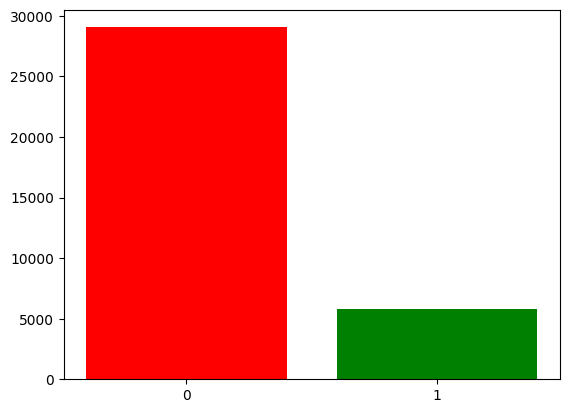

In [ ]:
all_labels = np.concatenate([labels for _, labels in dataset])

uniques, counts = np.unique(all_labels, return_counts=True)

plt.bar(uniques, counts, color=['r', 'g'])
plt.xticks(uniques)

print(counts[0] / counts[1])

In [ ]:
def plot_by_labels(epochs, labels):
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    for label in (0, 1):
        mean = epochs[labels == label].mean(axis=(0, 1))
        std = epochs[labels == label].std(axis=(0, 1))

        axes[0].plot(mean, label=captions[label])

        axes[1].plot(mean, label=captions[label])
        axes[1].fill_between(np.arange(mean.size), mean-std, mean+std, alpha=0.25)

    axes[0].legend(fontsize=20)
    axes[0].set_ylim(-0.16, 0.26)
    axes[1].set_ylim(-0.8, 0.85)
    for i, title in enumerate(('Means', 'Means with Stds')):
        axes[i].set_title(title, fontsize=20)
        axes[i].set_xticklabels(np.arange(-200, 1000, 200))
        axes[i].set_xlabel('milliseconds')

<ipython-input-17-3d474bf067c9>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(np.arange(-200, 1000, 200))


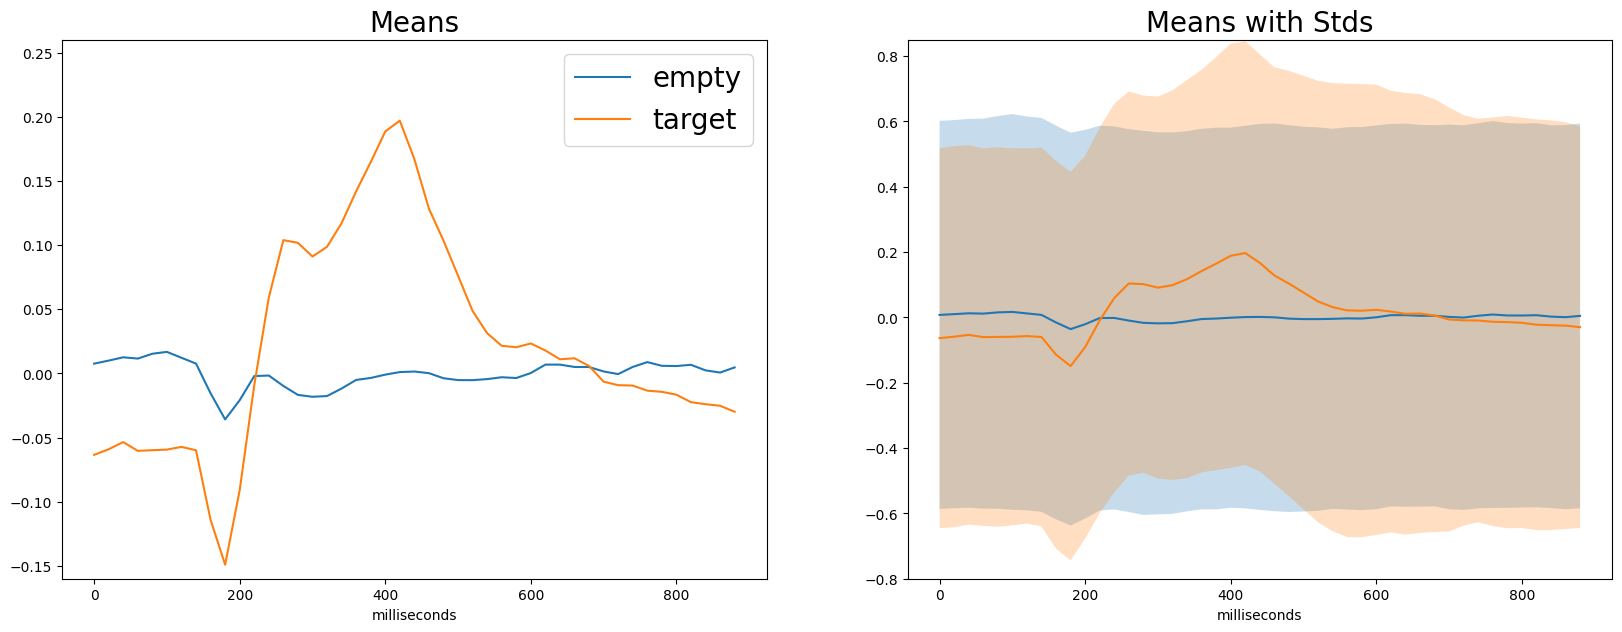

In [ ]:
plot_by_labels(all_epochs, all_labels)

<ipython-input-17-3d474bf067c9>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(np.arange(-200, 1000, 200))


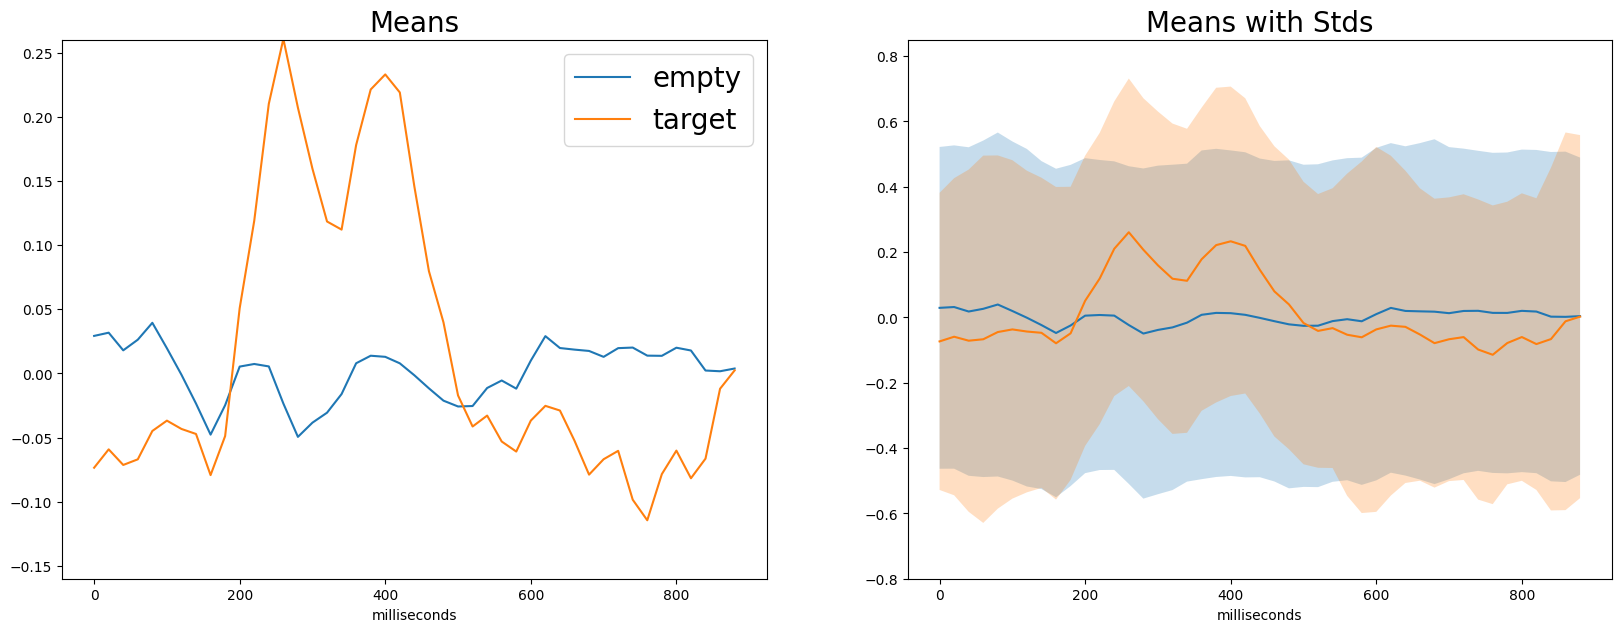

In [ ]:
plot_by_labels(dataset[6][0], dataset[6][1])

In [ ]:
data = dataset[0][0].copy()
target = dataset[0][1].copy()

In [ ]:
n = len(dataset)
n = 2
for i in range(1, n):
    data = np.concatenate((data, dataset[i][0]), axis=0)

In [ ]:
for i in range(1, n):
    target = np.concatenate((target, dataset[i][1]), axis=0)

In [ ]:
data.shape

(2844, 16, 45)

## Обнаружение признаков

Поскольку это данные временного ряда, я буду использовать среднее значение для обнаружения функции.

In [ ]:
def detect_feature(data, axis):
    if axis is None:
        return np.mean(data)
        # Alternatively, you can use np.sum(data) to calculate the sum
    else:
        return np.mean(data, axis=axis)

In [ ]:
detect_data = detect_feature(data, axis=(2))
detect_data.shape

(2844, 16)

In [ ]:
target.shape

(2844,)

In [ ]:
detect_data = detect_data.astype(np.float64)
target = target.astype(np.float64)

In [ ]:
detect_data[:5]

array([[ 0.06476296, -0.44705689,  0.12581113,  0.04131408,  0.13629719,
         0.07524552,  0.20519773,  0.14336432,  0.0847543 ,  0.14582472,
         0.1977367 ,  0.19860298,  0.12322733,  0.03983852,  0.01282198,
        -0.04726022],
       [ 0.04675599,  0.41242074, -0.01058863,  0.01230787,  0.01759967,
        -0.06488869, -0.08929471, -0.07074894, -0.05568962, -0.05060434,
        -0.04233106, -0.02185518,  0.01620837, -0.05510179, -0.00585891,
         0.04459932],
       [-0.02927971,  0.25844676, -0.05957528, -0.05334582, -0.11600296,
        -0.051579  , -0.10933402, -0.20931397,  0.01432779, -0.02213976,
        -0.07918582, -0.08078329, -0.04919605,  0.06012568,  0.08208763,
         0.09738408],
       [-0.05061872,  0.10417803, -0.03888227, -0.06875806, -0.11844842,
         0.01289592, -0.14188313, -0.2161041 , -0.04611261, -0.1139082 ,
        -0.1940749 , -0.19617634, -0.19631647, -0.01970821, -0.01965332,
        -0.02858071],
       [-0.04259896, -0.07397626, -0

# SVM - Машина опорных векторов

In [ ]:
import numpy as np


In [ ]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    np.random.seed(random_state)
    n_samples = len(X)
    test_indices = np.random.choice(n_samples, int(n_samples * test_size), replace=False)
    train_indices = np.array(list(set(range(n_samples)) - set(test_indices)))
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

In [ ]:
class SVM:
    def __init__(self, kernel='sigmoid', gamma='auto', learning_rate=0.01, max_iters=1000, random_state=None):
        self.kernel = kernel
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.random_state = random_state

    def fit(self, X, y, alpha=1):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        self.W = np.random.randn(n_features)
        self.b = 0

        for _ in range(self.max_iters):
            if self.kernel == 'sigmoid':
                activation = self.sigmoid(.dot(X, selfnp.W) + self.b)
            else:
                raise ValueError("Unsupported kernel type")

            errors = y - activation
            self.W += self.learning_rate * (np.dot(errors, X) - alpha * self.W)
            self.b += self.learning_rate * np.sum(errors)

    def predict(self, X):
        if self.kernel == 'sigmoid':
            activation = self.sigmoid(np.dot(X, self.W) + self.b)
        else:
            raise ValueError("Unsupported kernel type")
        return np.where(activation > 0.45, 1, 0)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(detect_data, target, test_size=0.2)


In [ ]:
print(X_train[:5])

[[ 0.06274155  0.0043045  -0.00246472 -0.062427    0.27064214  0.51240371
  -0.05049511  0.32161215  0.03408587 -0.08296688 -0.1323875  -0.1469823
  -0.19095125 -0.18326425 -0.45024333 -0.21193509]
 [ 0.41129376  0.3593424   0.36934563  0.37413011  0.19960997  0.10824896
   0.0956134   0.07994234  0.07455989  0.05668781  0.032959   -0.00188909
   0.05082756  0.09115624  0.0815051   0.03699102]
 [-0.1129563  -0.06275103 -0.0315708  -0.09280163  0.01131994 -0.02161205
   0.02753461  0.10805345  0.11535723  0.04433621  0.03036646  0.04331351
   0.08424859  0.17182875  0.06042833  0.09877457]
 [-0.03515286  0.02059664 -0.06400721 -0.06037874 -0.14984087 -0.05555798
  -0.27821539 -0.08994721 -0.09254492 -0.19853728 -0.22243961 -0.24281382
  -0.10783476 -0.06511229 -0.11384256 -0.0747812 ]
 [ 0.09507078  0.02635312  0.0740608   0.04284001  0.01043535  0.19827589
   0.06263347 -0.08428325  0.26749942  0.22395737  0.13676404  0.0076966
  -0.19357171  0.19159108  0.04675573  0.05221996]]


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(detect_data, target, test_size=0.2, random_state=42)

# Initialize the custom SVM classifier
svm = SVM(kernel='sigmoid', gamma='auto', learning_rate=0.01, max_iters=2200, random_state=42)

# Fit the custom SVM classifier to the training data
svm.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm.predict(X_test)



Accuracy: 0.8045774647887324


# Посчитать accuracy, precision, recall, F1-меру



* Accuracy

In [ ]:
def accuracy_score(y_true, y_pred):
    assert len(y_true) == len(y_pred), "Input lists must have the same length"
    n_correct = np.sum(np.array(y_true) == np.array(y_pred))
    accuracy = n_correct / len(y_true)
    return accuracy

In [ ]:
# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.8045774647887324


* Precision

In [ ]:
def precision_score(y_true, y_pred):
    assert len(y_true) == len(y_pred), "Input lists must have the same length"
    true_positives = np.sum((np.array(y_true) == 0) & (np.array(y_pred) == 0))
    false_positives = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 0))
    precision = true_positives / (true_positives + false_positives)
    return precision

In [ ]:
# Compute precision
precision = precision_score(y_test, y_pred)

print("Precision:", precision)

Precision: 0.8272058823529411


* Recall

In [ ]:
def recall_score(y_true, y_pred):
    assert len(y_true) == len(y_pred), "Input lists must have the same length"
    true_positives = np.sum((np.array(y_true) == 0) & (np.array(y_pred) == 0))
    false_negatives = np.sum((np.array(y_true) == 0) & (np.array(y_pred) == 10))
    recall = true_positives / (true_positives + false_negatives)
    return recall

In [ ]:
# Compute recall
recall = recall_score(y_test, y_pred)

print("Recall:", recall)

Recall: 1.0


* F1-score

In [ ]:
def f1_score(y_true, y_pred):
    assert len(y_true) == len(y_pred), "Input lists must have the same length"
    precision_val = precision_score(y_true, y_pred)
    recall_val = recall_score(y_true, y_pred)
    f1_score = 2 * (precision_val * recall_val) / (precision_val + recall_val)
    return f1_score

In [ ]:
# Compute recall
f1 = f1_score(y_test, y_pred)

print("F1-score:", f1)

F1-score: 0.9054325955734406


# Вывести ROC-кривую

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
def roc_curve(y_true, y_scores):
    # Sort the true labels and corresponding scores in descending order
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    y_scores_sorted = y_scores[sorted_indices]

    # Initialize arrays to store true positive rate (TPR) and false positive rate (FPR)
    tpr = np.zeros(len(y_true) + 1)
    fpr = np.zeros(len(y_true) + 1)

    # Set the initial values of TPR and FPR to 0
    tpr[0] = 0
    fpr[0] = 0

    # Calculate TPR and FPR for each threshold
    for i in range(1, len(y_true) + 1):
        # Count the number of true positive, false positive, true negative, and false negative samples
        tp = np.sum((y_true_sorted[:i] == 1))
        fp = np.sum((y_true_sorted[:i] == 0))
        tn = np.sum((y_true_sorted[i:] == 0))
        fn = np.sum((y_true_sorted[i:] == 1))

        # Calculate TPR and FPR
        tpr[i] = tp / (tp + fn)
        fpr[i] = fp / (fp + tn)

    return fpr, tpr

def auc(fpr, tpr):
    # Calculate the area under the curve (AUC) using the trapezoidal rule
    auc_score = np.trapz(tpr, fpr)
    return auc_score

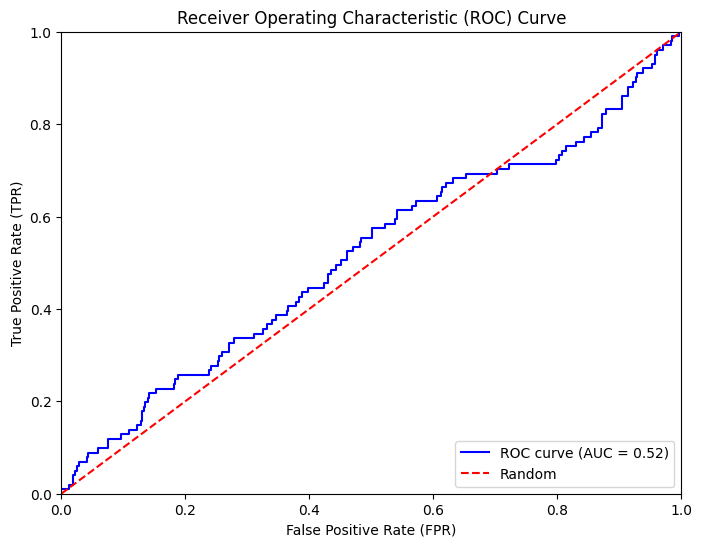

In [ ]:
# Calculate false positive rate (FPR), true positive rate (TPR)
fpr, tpr = roc_curve(y_test, y_pred)
# Calculate Area Under the Curve (AUC) score
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()